TEAM ID -: 1



KARAN SINGH 2022CSM1008
NITIN SINGHAL 2022CSM1011

In [ ]:
import numpy as np
import math
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples
from sklearn.metrics import silhouette_score
from collections import deque
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [ ]:
standardTimeSlice=5
threshold = 1

In [ ]:
#random data set generation
def return_number_process():
  return np.random.randint(10, 20)

#random burst time
def return_burst_time(numProcess,std):
  return abs(np.random.normal(loc=0.0, scale=std, size=numProcess))



In [ ]:
#data preprocing
def createDataSet(std,numberprocess):
  burstTimes = return_burst_time(numberprocess,std)
  processIds = [i for i in range(0,numberprocess)]
  processIds = np.array(processIds)
  return numberprocess,burstTimes,processIds


#data preprocessing
def dataPreprocing(burstTimes):
  totalBurstTime = np.sum(burstTimes)
  processWeight = [ i/totalBurstTime for i in burstTimes]
  processWeight = np.array(processWeight)
  numberOfContextSwitches = [math.floor(i/standardTimeSlice) if i%standardTimeSlice != 0 else (i/standardTimeSlice)-1 for i in burstTimes]
  numberOfContextSwitches = np.array(numberOfContextSwitches)
  dataset = [[i,j,k,m] for i,j,k,m in zip(burstTimes,processWeight,numberOfContextSwitches,burstTimes)]
  df=pd.DataFrame(dataset)
  df.columns=["burstTime","processWeight","NCS","OriginalBurstTime"]
  return df,processWeight

In [ ]:
#implementation of the paper
def findOptimalCluster(df):
 # Define range of k values to test
  if df.shape[0]>7:
    k_range = range(2, 7)
  else:
    k_range=range(2,df.shape[0])


  # Calculate silhouette score for each k value
  silhouette_scores = []
  if(df.shape[0]>7):
    for k in range(2,7):
        kmeans = KMeans(n_clusters=k)
        kmeans.fit(df)
        labels = kmeans.labels_
        score = silhouette_score(df, labels)
        silhouette_scores.append(score)
        optimal_k = 1
        if len(silhouette_scores) > 0 :
          optimal_k = k_range[silhouette_scores.index(max(silhouette_scores))]
          km=KMeans(n_clusters=optimal_k)
          t=km.fit(df)
  else:
  # Find optimal k value with highest silhouette score
    optimal_k = 2
    km=KMeans(n_clusters=optimal_k)
    t=km.fit(df)
  return optimal_k,km


def dynamicKmeans(df):
      contextSwitches=0
      processData = df.to_numpy()
      turnaroundTime = []
      waitingTime = []
      timer = 0
      lengthOfDataset = df.shape[0]
      while processData.shape[0] > 0 :
        df,processWeight=dataPreprocing(processData[:, 0])
        processData = df.to_numpy()
        if df.shape[0] > 1 :
          optimalCuster,km = findOptimalCluster(df)
          totalCountInClusters = [0 for i in range (0,optimalCuster)]
          totalWeightInCluster = [0 for i in range (0,optimalCuster)]
          for i in range (0,df.shape[0]):
            index = km.labels_[i]
            totalCountInClusters[index]=totalCountInClusters[index]+1
            totalWeightInCluster[index]=totalWeightInCluster[index]+processWeight[i]
          avgWeightOfClusters = [i/j for i,j in zip(totalCountInClusters,totalWeightInCluster)]
          totalAvgWeightOfCluster = np.sum(avgWeightOfClusters)
          clusterWeight=[((i/totalAvgWeightOfCluster)) for i in avgWeightOfClusters]
          clusterTimeQuantum = [((i/totalAvgWeightOfCluster))*standardTimeSlice for i in avgWeightOfClusters]
          j=0
          deleteprocessid=[]
          while j < processData.shape[0] :
                contextSwitches=contextSwitches+1
                if processData[j][0] > clusterTimeQuantum[km.labels_[j]] :
                  timer=timer+clusterTimeQuantum[km.labels_[j]]
                  processData[j][0] = processData[j][0] - clusterTimeQuantum[km.labels_[j]]
                else :
                  timer=timer+processData[j][0]
                  turnaroundTime.append(timer)
                  waitingTime.append(timer-processData[j][3])
                  processData=np.delete(processData,j,axis=0)
                  j=j-1
                j=j+1
        else :
          timer=timer+processData[0][0]
          if timer < processData[0][3]:
              waitingTime.append(timer)
          else :
              waitingTime.append(timer-processData[0][3])
          processData=np.delete(processData,0,axis=0)


      avgturnaroundTime = 0
      contextSwitches=contextSwitches  >> 2
      for i in  turnaroundTime :
        avgturnaroundTime = avgturnaroundTime+i
      avgturnaroundTime = avgturnaroundTime /lengthOfDataset
      avgWaitingTime = 0
      for i in waitingTime :
        avgWaitingTime = avgWaitingTime+i
      avgWaitingTime = avgWaitingTime /lengthOfDataset
      return avgturnaroundTime,avgWaitingTime,contextSwitches




In [ ]:
def proportionalWeightedRoundRobin(burstTimes,standardTimeSlice):
    contextSwitches = 0
    burstTimes = np.array(burstTimes)
    processWeight = burstTimes / np.sum(burstTimes)
    numberOfContextSwitches = np.floor(burstTimes / standardTimeSlice)
    numberOfContextSwitches[burstTimes % standardTimeSlice == 0] -= 1

    dataset = np.column_stack((burstTimes, processWeight, numberOfContextSwitches, burstTimes))

    turnaroundTime = []
    waitingTime = []
    timer = 0
    lengthOfDataset = dataset.shape[0]
    while dataset.shape[0] > 0:
        if dataset.shape[0] > 1:
            totalBurstTime = np.sum(dataset[:, 0])
            totalProcessWeight = np.sum(dataset[:, 1])
            clusterTimeQuantum = (1 - (dataset[:, 1] / totalProcessWeight)) * standardTimeSlice

            j = 0
            while j < dataset.shape[0]:
                contextSwitches += 1
                if dataset[j][0] > clusterTimeQuantum[j]:
                    timer += clusterTimeQuantum[j]
                    dataset[j][0] -= clusterTimeQuantum[j]
                    if dataset[j][0] <= threshold:
                        timer += dataset[j][0]
                        turnaroundTime.append(timer)
                        waitingTime.append(max(timer - dataset[j][3], 0))
                        dataset = np.delete(dataset, j, axis=0)
                    else:
                        j += 1
                else:
                    timer += dataset[j][0]
                    turnaroundTime.append(timer)
                    waitingTime.append(max(timer - dataset[j][3], 0))
                    dataset = np.delete(dataset, j, axis=0)
        else:
            timer += dataset[0][0]
            waitingTime.append(max(timer - dataset[0][3], 0))
            dataset = np.delete(dataset, 0, axis=0)

    avgTurnaroundTime = np.mean(turnaroundTime)
    avgWaitingTime = np.mean(waitingTime)
    return avgTurnaroundTime, avgWaitingTime, contextSwitches

In [ ]:
def roundRobin(burstTimes, timeQuantum):
    n = len(burstTimes)
    remainingBurstTimes = list(burstTimes)  # Create a copy of burstTimes
    queue = deque()
    waitingTime = [0] * n
    turnaroundTime = [0] * n
    contextSwitches = 0
    timer = 0

    # Add all processes to the queue
    for i in range(n):
        queue.append(i)

    # Execute processes in the queue until all are completed
    while queue:
        currentProcess = queue.popleft()
        contextSwitches += 1
        if remainingBurstTimes[currentProcess] > timeQuantum:
            timer += timeQuantum
            remainingBurstTimes[currentProcess] -= timeQuantum
            queue.append(currentProcess)
        else:
            timer += remainingBurstTimes[currentProcess]
            waitingTime[currentProcess] = timer - burstTimes[currentProcess]
            turnaroundTime[currentProcess] = timer
            remainingBurstTimes[currentProcess] = 0

    avgWaitingTime = sum(waitingTime) / n
    avgTurnaroundTime = sum(turnaroundTime) / n

    return avgTurnaroundTime, avgWaitingTime, contextSwitches

In [ ]:
# Implementation of Amended Dynamic Round Robin (ADRR)
def amendedDynamicRoundRobin(burstTimes,standardTimeSlice):
    contextSwitches = 0
    processWeight = burstTimes / np.sum(burstTimes)
    dataset = np.column_stack((burstTimes, processWeight))

    turnaroundTime = []
    waitingTime = []
    timer = 0
    lengthOfDataset = dataset.shape[0]

    while dataset.shape[0] > 0:
        for i in range(dataset.shape[0]):
            contextSwitches += 1
            if dataset[i][0] > standardTimeSlice:
                timer += standardTimeSlice
                dataset[i][0] -= standardTimeSlice
                if dataset[i][0] <= threshold:
                    timer += dataset[i][0]
                    waitingTime.append(max(timer - burstTimes[i], 0))
                    dataset = np.delete(dataset, i, axis=0)
                    turnaroundTime.append(timer)
                    break
            else:
                timer += dataset[i][0]
                waitingTime.append(max(timer - burstTimes[i], 0))
                dataset = np.delete(dataset, i, axis=0)
                turnaroundTime.append(timer)
                break

    avgTurnaroundTime = np.mean(turnaroundTime)
    avgWaitingTime = np.mean(waitingTime)
    return avgTurnaroundTime, avgWaitingTime, contextSwitches

In [ ]:
# Implementation of Variable Time Round-Robin (VTRR)
def variableTimeRoundRobin(burstTimes,standardTimeSlice):
    contextSwitches = 0
    remainingBurstTimes = np.copy(burstTimes)
    turnaroundTime = []
    waitingTime = []
    timer = 0
    lengthOfDataset = len(burstTimes)

    while np.sum(remainingBurstTimes) > 0:
        for i in range(lengthOfDataset):
            if remainingBurstTimes[i] > 0:
                contextSwitches += 1
                if remainingBurstTimes[i] > standardTimeSlice:
                    timer += standardTimeSlice
                    remainingBurstTimes[i] -= standardTimeSlice
                else:
                    timer += remainingBurstTimes[i]
                    waitingTime.append(max(timer - burstTimes[i], 0))
                    remainingBurstTimes[i] = 0
                    turnaroundTime.append(timer)

    avgTurnaroundTime = np.mean(turnaroundTime)
    avgWaitingTime = np.mean(waitingTime)
    return avgTurnaroundTime, avgWaitingTime, contextSwitches

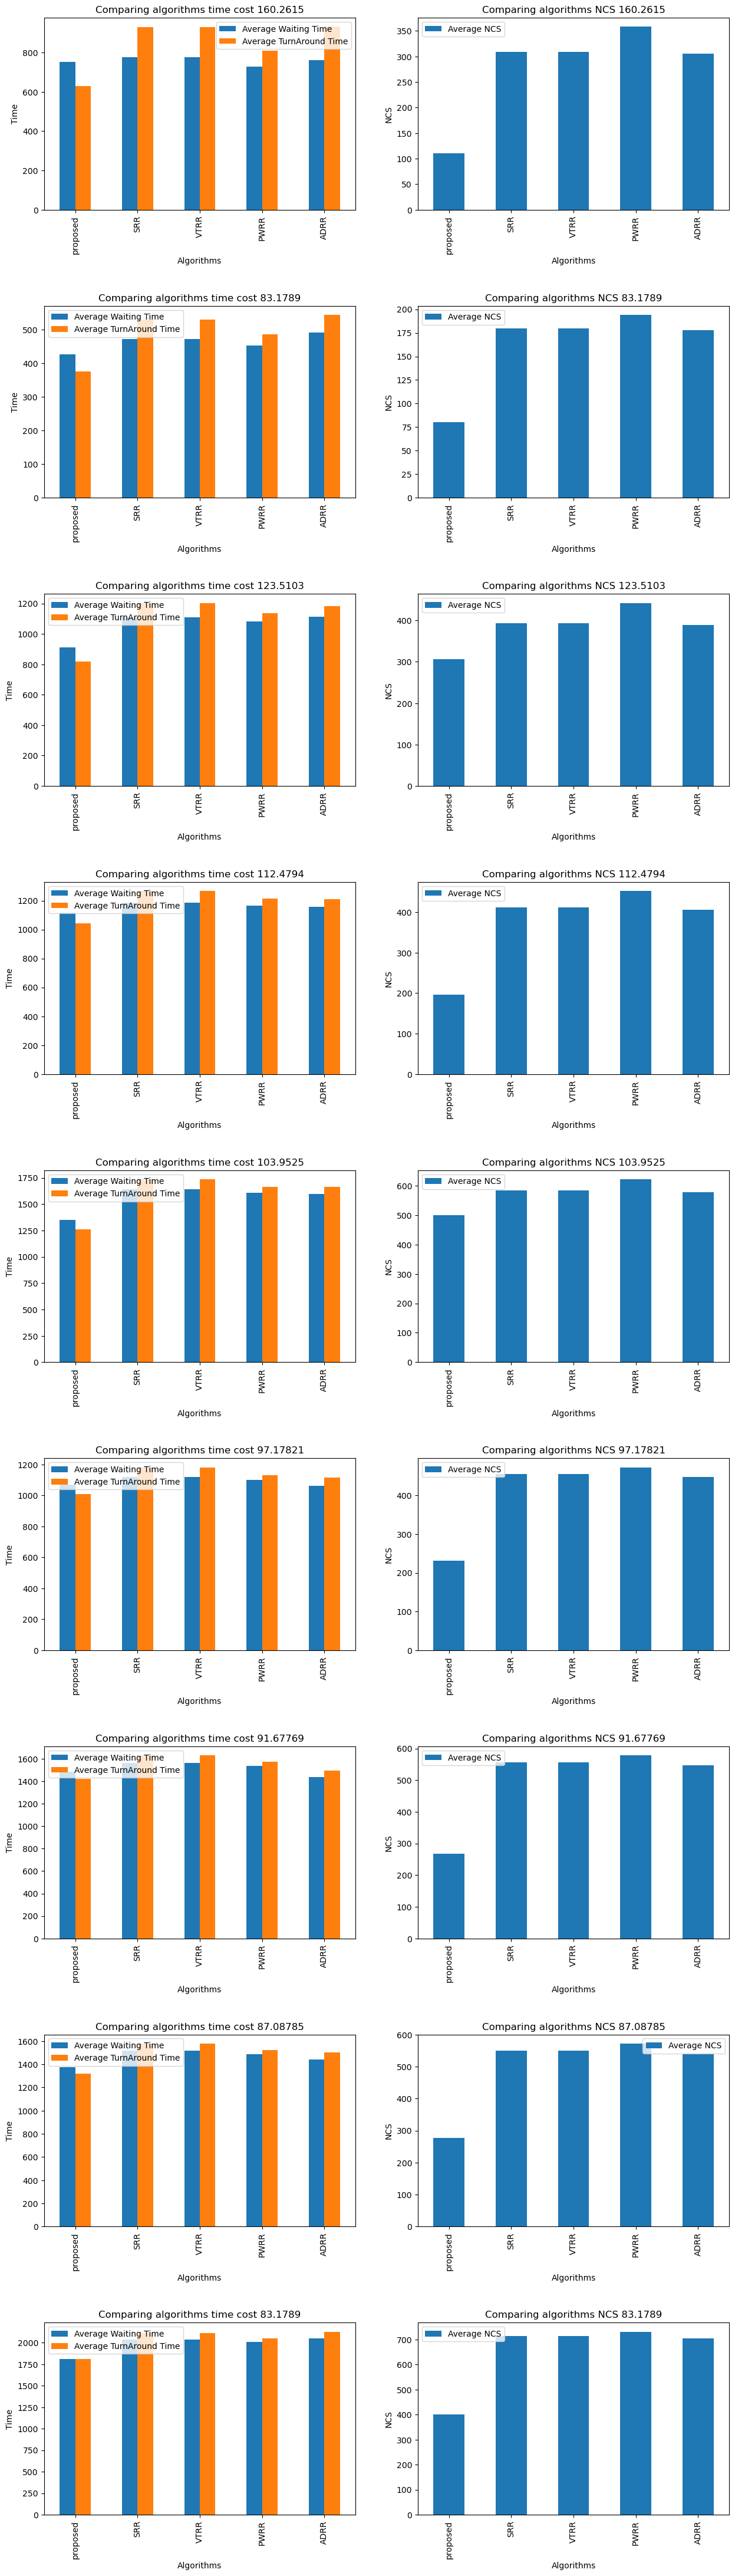

In [ ]:
alo_name=["proposed","SRR","VTRR","PWRR","ADRR"]
standard_deviation=[160.2615,83.1789,123.5103,112.4794,103.9525,97.17821,91.67769,87.08785,83.1789]
number_of_process = [10,15,20,25,30,35,40,45,50]
averageWaintingTimeList=[]
averageTurnAroundTimeList=[]
contextSwitchingList=[]
k=0
fig, axs = plt.subplots(9, 2)
fig.subplots_adjust(hspace=0.5)
for i,j in zip(standard_deviation,number_of_process):
    averageWaintingTimeList=[]
    averageTurnAroundTimeList=[]
    contextSwitchingList=[]
    numberOfProcess,burstTimes,processIds = createDataSet(i,j)
    df,processWeight=dataPreprocing(burstTimes)
    avgTurnaroundTime,avgWaitingTime,contextSwitches = dynamicKmeans(df)
    averageTurnAroundTimeList.append(avgTurnaroundTime)
    averageWaintingTimeList.append(avgWaitingTime)
    contextSwitchingList.append(contextSwitches)

    avgTurnaroundTime, avgWaitingTime, contextSwitches = roundRobin(burstTimes,standardTimeSlice)
    averageTurnAroundTimeList.append(avgTurnaroundTime)
    averageWaintingTimeList.append(avgWaitingTime)
    contextSwitchingList.append(contextSwitches)

    avgTurnaroundTime, avgWaitingTime, contextSwitches = variableTimeRoundRobin(burstTimes,standardTimeSlice)
    averageTurnAroundTimeList.append(avgTurnaroundTime)
    averageWaintingTimeList.append(avgWaitingTime)
    contextSwitchingList.append(contextSwitches)


    avgTurnaroundTime, avgWaitingTime, contextSwitches = proportionalWeightedRoundRobin(burstTimes,standardTimeSlice)
    averageTurnAroundTimeList.append(avgTurnaroundTime)
    averageWaintingTimeList.append(avgWaitingTime)
    contextSwitchingList.append(contextSwitches)

    avgTurnaroundTime, avgWaitingTime, contextSwitches = amendedDynamicRoundRobin(burstTimes,standardTimeSlice)
    averageTurnAroundTimeList.append(avgTurnaroundTime)
    averageWaintingTimeList.append(avgWaitingTime)
    contextSwitchingList.append(contextSwitches)




    plotdata = pd.DataFrame({

        "Average Waiting Time":averageWaintingTimeList,

        "Average TurnAround Time":averageTurnAroundTimeList,},

        index=alo_name)


    plotdata.plot(kind="bar",ax=axs[k,0],figsize=(15, 55))
    axs[k,0].set_title("Comparing algorithms time cost {}".format(standard_deviation[k]))
    axs[k,0].set_xlabel("Algorithms")
    axs[k,0].set_ylabel("Time")



    plotdata = pd.DataFrame({

        "Average NCS":contextSwitchingList},

        index=alo_name)
    plotdata.plot(kind="bar",ax=axs[k,1],figsize=(15, 55))
    axs[k,1].set_title("Comparing algorithms NCS {}".format(standard_deviation[k]))
    axs[k,1].set_xlabel("Algorithms")
    axs[k,1].set_ylabel("NCS")

    k=k+1
plt.show()
